In [332]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from prophet import Prophet


In [333]:
df = pd.read_csv("./data/train.csv", parse_dates=True, index_col='date')
#df.isna().any() #Tutti false

transactions = pd.read_csv("./data/transactions.csv", parse_dates=True, index_col='date')
#transactions

In [334]:
#oil_data= pd.read_csv("data/oil.csv", parse_dates=True, index_col='date')
#oil_data= oil_data.dropna()
#df = df.merge(oil_data, on='date', how='left')
#df.dcoilwtico = df.dcoilwtico.fillna(65)
df

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0
2013-01-01,1,1,BABY CARE,0.000,0
2013-01-01,2,1,BEAUTY,0.000,0
2013-01-01,3,1,BEVERAGES,0.000,0
2013-01-01,4,1,BOOKS,0.000,0
...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0
2017-08-15,3000884,9,PREPARED FOODS,154.553,1
2017-08-15,3000885,9,PRODUCE,2419.729,148


In [335]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [336]:
encoder= OrdinalEncoder()
encoder.fit(df[["family"]])
df["family"]= encoder.transform(df[["family"]])

df = df[df.store_nbr == 8]
df = df[df.family == 5.0]
del df["store_nbr"]
del df["family"]
del df["id"]

transactions = transactions[transactions.store_nbr == 8]
del transactions["store_nbr"]

In [337]:
transactions

,transactions
date,
2013-01-02,3250
2013-01-03,2904
2013-01-04,2962
2013-01-05,3060
2013-01-06,2748
...,...
2017-08-11,2212
2017-08-12,2463
2017-08-13,2355


In [338]:
df

,sales,onpromotion
date,,
2013-01-01,0.000,0
2013-01-02,768.050,0
2013-01-03,568.395,0
2013-01-04,512.527,0
2013-01-05,731.277,0
...,...,...
2017-08-11,655.410,10
2017-08-12,809.417,12
2017-08-13,793.814,10


In [348]:
df = df.merge(transactions, on='date', how='left')
df

,sales,onpromotion,transactions
date,,,
2013-01-01,0.000,0,NaN
2013-01-02,768.050,0,3250.0
2013-01-03,568.395,0,2904.0
2013-01-04,512.527,0,2962.0
2013-01-05,731.277,0,3060.0
...,...,...,...
2017-08-11,655.410,10,2212.0
2017-08-12,809.417,12,2463.0
2017-08-13,793.814,10,2355.0


In [ ]:
df.transactions.isna().sum()
is_NaN = xxx.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

print(rows_with_NaN)

In [339]:
df_train = df[:'2016']
df_train = df_train.reset_index()
df_train.columns = ['ds', 'y', 'onpromotion']

df_test = df['2017']
df_test = df_test.reset_index()
df_test.columns = ['ds', 'y', 'onpromotion']

df_test

,ds,y,onpromotion
0,2017-01-01,0.000,0
1,2017-01-02,1291.372,2
2,2017-01-03,971.064,3
3,2017-01-04,990.892,9
4,2017-01-05,822.203,9
...,...,...,...
222,2017-08-11,655.410,10
223,2017-08-12,809.417,12
224,2017-08-13,793.814,10
225,2017-08-14,815.009,10


In [340]:
hd = pd.read_csv("./data/holidays_events.csv", parse_dates=True, index_col='date')
#hd.isna().any() #Non ce ne sono

t = hd[hd.locale == "National"]
t = t[t.locale_name == "Ecuador"]
t = t[t.type != "Work Day"]
t = t[t.transferred == False]
t = t[t.type != "Additional"]
t = t[t.type != "Transfer"]
del t["transferred"]
del t["description"]
del t["locale_name"]
del t["locale"]
t.type.unique()

array(['Holiday', 'Bridge', 'Event'], dtype=object)

In [341]:
t["festa"] = t.index.day + t.index.month*100

diz = {}
for n in np.asarray(t.festa):
    try:
        diz[n] += 1
    except:
        diz[n] = 1

#{k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}


In [342]:
res = []
a = ['11-02','11-03','12-25','05-01','08-10','01-01','05-24','10-09']
b = ["a", "b", "c", "d", "e", "f", "g", "h"]
for x in range(2013, 2017+1):
    for y in a:
        res.append(str(x)+"-"+y)

holidays = pd.DataFrame({'ds': res, 'holiday': b*5})
#holidays

In [343]:
model = Prophet(holidays=holidays, yearly_seasonality=5, seasonality_mode='multiplicative')
#model.add_regressor('family')
#model.add_regressor('onpromotion')
#model.add_regressor('oilprice')
#model.add_regressor('store_nbr')
model.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE 2019: 118.72837436123496


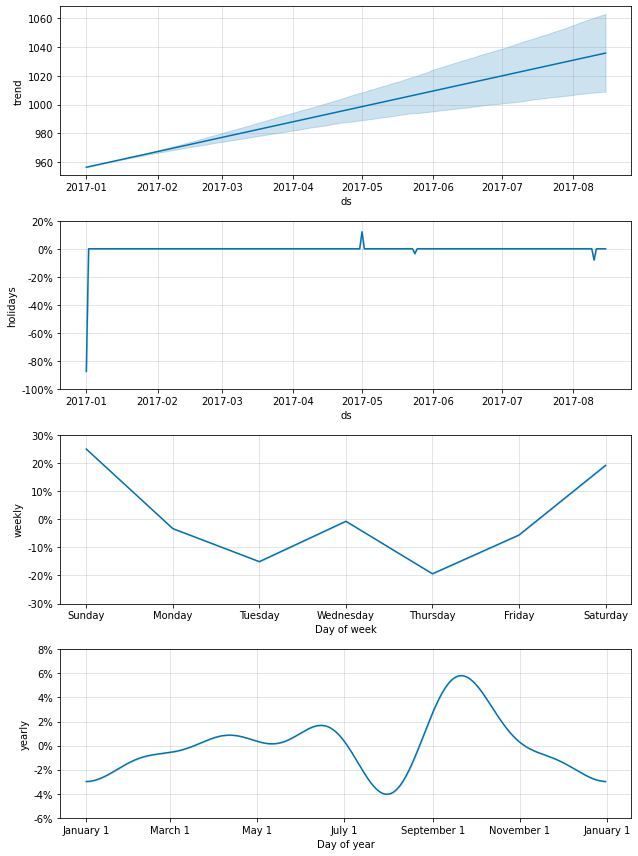

In [344]:
future = model.make_future_dataframe(periods=df_test.shape[0], include_history=False)
#future["onpromotion"] = df_test["onpromotion"]
#future["oilprice"] = df_test["oilprice"]
predictions = model.predict(future)
#predictions = predictions[["ds", "yhat"]]
#predictions
print("MAE 2019: {}".format(mean_absolute_error(y_true=df_test.y, y_pred=predictions.yhat)))
_ = model.plot_components(predictions)